# Classifying cancer expression vectors

In this assignment you will train a neural network to identify the tissue type that produced an RNA expression vector. The dataset is comprised of RNA-seq data obtained from tumors. 

For a complete description of the data collection workflow see this page:
https://xenabrowser.net/datapages/?host=https://toil.xenahubs.net

And for the corresponding publication:
https://doi.org/10.1038/nbt.3772

In [108]:
import sys
import numpy as np
from matplotlib import pyplot
import pandas as pd
import h5py
import os
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

print("USING pytorch VERSION: ", torch.__version__)

USING pytorch VERSION:  1.3.1


## Loading and parsing training data
For this problem, expression data needs to be loaded and pruned. Initially, there are >50,000 genes in each expression vector, which can be reduced to a much smaller gene set for the sake of minimizing computation time. Here, the data is subsetted to only include genes from the KEGG gene set. You may want to consider reducing or expanding this dataset to get a better understanding of which genes are predictive, though this is not a requirement for the assignment.

For a list of gene sets, check out the MSigDB collections page: http://software.broadinstitute.org/gsea/msigdb/collections.jsp

This script was adapted from Rob Currie's ingestion script: https://github.com/rcurrie/tumornormal/blob/master/genesets.ipynb

We have placed a subset of this data for this homework in Google drive, you can download it here:

https://drive.google.com/drive/folders/1pPABQDEHCddPTJAhfD6G5KyBDJiK3unQ?usp=sharing

In [2]:
# Load the data - If using Google drive link to access data the following with connect
# to drive, authenticate using your Google account and load the data

!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#x_test: https://drive.google.com/file/d/1Cc4zEw1wANFX8S44L87Rx_EZWwCcONMW/view?usp=sharing
#x_train: https://drive.google.com/file/d/1s8VvRaUc62OYukRunV689Y9u-v_y7KRl/view?usp=sharing
#y_test: https://drive.google.com/file/d/1W4Qdr3zm5QYGP5ncMQSurrO1m05KsKQ2/view?usp=sharing
#t_train: https://drive.google.com/file/d/1UmDZ25W84DmIY4im2XHCAc5QGgNkdexD/view?usp=sharing

# 2. Now proxy the Google Drive files to a local file
x_test_import = drive.CreateFile({'id':'1Cc4zEw1wANFX8S44L87Rx_EZWwCcONMW'})
x_train_import = drive.CreateFile({'id':'1s8VvRaUc62OYukRunV689Y9u-v_y7KRl'})
y_test_import = drive.CreateFile({'id':'1W4Qdr3zm5QYGP5ncMQSurrO1m05KsKQ2'})
y_train_import = drive.CreateFile({'id':'1UmDZ25W84DmIY4im2XHCAc5QGgNkdexD'})

x_test_import.GetContentFile('x_test.npz') # x_test.npz is the file name that will be accessible in the notebook.
x_train_import.GetContentFile('x_train.npz') # x_train.npz is the file name that will be accessible in the notebook.
y_test_import.GetContentFile('y_test.npz') # y_test.npz is the file name that will be accessible in the notebook.
y_train_import.GetContentFile('y_train.npz') # y_train.npz is the file name that will be accessible in the notebook.

y_index_key = {'Adipose Tissue': 0, 'Adrenal Gland': 1, 'Adrenal gland': 2, 
               'Bile duct': 3, 'Bladder': 4, 'Blood': 5, 'Blood Vessel': 6, 
               'Bone Marrow': 7, 'Brain': 8, 'Breast': 9, 'Cervix': 10, 
               'Cervix Uteri': 11, 'Colon': 12, 'Endometrium': 13, 
               'Esophagus': 14, 'Eye': 15, 'Fallopian Tube': 16, 
               'Head and Neck region': 17, 'Heart': 18, 'Kidney': 19, 
               'Lining of body cavities': 20, 'Liver': 21, 'Lung': 22, 
               'Lymphatic tissue': 23, 'Muscle': 24, 'Nerve': 25, 'Ovary': 26, 
               'Pancreas': 27, 'Paraganglia': 28, 'Pituitary': 29, 'Prostate': 30,
               'Rectum': 31, 'Salivary Gland': 32, 'Skin': 33, 'Small Intestine': 34,
               'Soft tissue,Bone': 35, 'Spleen': 36, 'Stomach': 37, 
               'SympatheticÊNervous System': 38, 'Testis': 39, 'Thymus': 40,
               'Thyroid': 41, 'Thyroid Gland': 42, 'Uterus': 43, 'Vagina': 44,
               'White blood cell': 45}

for name in y_index_key:
  print(name, y_index_key[name])

Adipose Tissue 0
Adrenal Gland 1
Adrenal gland 2
Bile duct 3
Bladder 4
Blood 5
Blood Vessel 6
Bone Marrow 7
Brain 8
Breast 9
Cervix 10
Cervix Uteri 11
Colon 12
Endometrium 13
Esophagus 14
Eye 15
Fallopian Tube 16
Head and Neck region 17
Heart 18
Kidney 19
Lining of body cavities 20
Liver 21
Lung 22
Lymphatic tissue 23
Muscle 24
Nerve 25
Ovary 26
Pancreas 27
Paraganglia 28
Pituitary 29
Prostate 30
Rectum 31
Salivary Gland 32
Skin 33
Small Intestine 34
Soft tissue,Bone 35
Spleen 36
Stomach 37
SympatheticÊNervous System 38
Testis 39
Thymus 40
Thyroid 41
Thyroid Gland 42
Uterus 43
Vagina 44
White blood cell 45



## Define a pytorch Dataset object to contain the training and testing data
Pytorch handles data shuffling and batch loading, as long as the user provides a "Dataset" class. This class is just a wrapper for your data that casts the data into pytorch tensor format and returns slices of the data. In this case, our data has been stored in numpy format, which conveniently pytorch has a method for converting to their native format.

In [0]:
class PrimarySiteDataset(Dataset):
    def __init__(self, x_path, y_path, batch_size=None):
        x = np.load(x_path)['a']
        y = np.load(y_path)['a']

        x_dtype = torch.FloatTensor
        y_dtype = torch.FloatTensor     # for MSE Loss

        self.length = x.shape[0]

        self.x_data = torch.from_numpy(x).type(x_dtype)
        self.y_data = torch.from_numpy(y).type(y_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

## Define training methods for the model
These methods use an initialized model and training data to iteratively perform the forward and backward pass of optimization. Aside from some data reformatting that depends on the input, output, and loss function, these methods will always be the same for any shallow neural network.

## **train_batch()**

train_batch has the purpose of training a batch of the data set. 

**Inputs:** Shallow linear model, x_train set, y_train set, SGD optimizer, MSE loss function

**Output:** loss score 

In [0]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)

    # convert 1-hot vectors into indicies
    max_values, target_index = y.max(dim=1)
    target_index = target_index.type(torch.LongTensor)
    
    # Compute loss.
    loss = loss_fn(y_predict, target_index)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

    return loss.data.item()



## **train()**
Function that trains the model using the given x_train and y_train set.

**Input:** shallow linear model, dataloader for train_set, SGD optimizer, MSE loss function, # of epochs

**Output:** the loss score of each batch (list data type)

In [0]:
def train(model, loader, optimizer, loss_fn, epochs=5):
    losses = list()

    batch_index = 0
    for e in range(epochs):
        for x, y in loader:
            loss = train_batch(model=model, x=x, y=y, 
                               optimizer=optimizer, loss_fn=loss_fn)
            losses.append(loss)

            batch_index += 1

        print("Epoch: ", e+1)
        print("Batches: ", batch_index)

    return losses

## **test_batch()**
Function that tests the model using the given x_test and y_test set.

**Input:** shallow linear model, $x$, $y$

**Output:** $y$ and $y'$

In [0]:
def test_batch(model, x, y):
    # run forward calculation
    y_predict = model.forward(x)

    return y, y_predict

## **test()**
Function that tests the model using the given x_test and y_test set.

**Input:** shallow linear model, data loader for test set

**Output:** $y'$ numpy vector

In [0]:
def test(model, loader):
    y_vectors = list()
    y_predict_vectors = list()

    batch_index = 0
    for x, y in loader:
        y, y_predict = test_batch(model=model, x=x, y=y)

        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())

        batch_index += 1

    y_predict_vector = np.concatenate(y_predict_vectors)
    y_vector = np.concatenate(y_vectors)

    return y_vector, y_predict_vector

## **plot_loss()**
Plots the loss of the given train session

**Input:** list of losses by batch

**Output:** a graph of losses vs iterations.

In [0]:
def plot_loss(losses, show=True):
    fig = pyplot.gcf()
    fig.set_size_inches(8,6)
    ax = pyplot.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    pyplot.plot(x_loss, losses)

    if show:
        pyplot.show()

    pyplot.close()

## **class ShallowLinear()**
The class prouduces a linear nueral network with linear connections between each layer.

**Attributes:** 
* linear1, linear2, linear3: each is a linear connection between 2 repsective layers. 

**Functions:**
* *forward()* - obtains hidden layer and then preforms relu activation function and then returns x once it passes the output layer. 

In [0]:
class ShallowLinear(nn.Module):
    '''
    A simple, general purpose, fully connected network
    '''
    def __init__(self):
        # Perform initialization of the pytorch superclass
        super(ShallowLinear, self).__init__()
        
        # Define network layer dimensions
        D_in, H1, H2, D_out = [5172, 32, 32, 46]    
        # These numbers correspond to each layer: [input, hidden_1, output]
        
        # Define layer types
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

    def forward(self, x):
        '''
        This method defines the network layering and activation functions
        '''
        x = self.linear1(x) # hidden layer
        x = torch.relu(x)       # activation function
        
        x = self.linear2(x) # hidden layer
        x = torch.relu(x)       # activation function
        
        x = self.linear3(x) # output layer

        x = F.log_softmax(x)
        
        return x

## **run()**
loads the data sets with DataLoader and using given hyperparameters, trains and tests the model

**Input:** train dataset, test dataset

**Output:** loss array, y_prediction npy

In [0]:
def run(dataset_train, dataset_test):
    # Batch size is the number of training examples used to calculate each iteration's gradient
    batch_size_train = 32
    
    data_loader_train = DataLoader(dataset=dataset_train, 
                                   batch_size=batch_size_train, shuffle=True)
    data_loader_test = DataLoader(dataset=dataset_test, 
                                  batch_size=len(dataset_test), shuffle=False)
    
    # Define the hyperparameters
    learning_rate = 1e-3
    shallow_model = ShallowLinear()
    
    n_epochs = 10
    
    # Initialize the optimizer with above parameters
    optimizer = optim.SGD(shallow_model.parameters(), lr=learning_rate)

    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()  # mean squared error

    # Train and get the resulting loss per iteration
    loss = train(model=shallow_model, loader=data_loader_train, 
                 optimizer=optimizer, loss_fn=loss_fn, epochs=n_epochs)
    
    # Test and get the resulting predicted y values
    y, y_predict = test(model=shallow_model, loader=data_loader_test)

    return loss, y, y_predict

## **argmax()**
Returns the indicies of the max value in a given test from $y$ and $y'$ respectively.

**Input:** a single $y$ output and $y'$ output.

**Output:** max index of the $y$ and $y'$ output.

In [0]:
def argmax(y_predict, y):
  ''' '''
  Y = list(y)
  Ypred = list(y_predict)
  maxY = max(Y)
  maxYpred = max(Ypred)
  Yindex = Y.index(maxY)
  predIndex = Ypred.index(maxYpred)

  return Yindex, predIndex


## **accuracy()**
Finds the error rate of the model given the $y$ and $y'$ output arrays.

**Input:** the array of $y$ output and $y'$ output.

**Output:** error rate, the argmax values of $y$ per test.

In [0]:
def accuracy(y, y_predict):
  noMatch = 0
  maxValues = list()
  maxValuesPrime = list()
  for number in range(len(y)):
    yval, yprime = argmax(y_predict[number], y[number])
    if yval != yprime: noMatch+=1
    maxValues.append(yval)
    maxValuesPrime.append(yprime)
  
  return (noMatch/len(y)), maxValues, maxValuesPrime

## **plot_argMax()**
Plots the distribution of the $y$ test output.

**Input:** the array of $y$ output.

**Output:** None

In [0]:
def plot_argMax(argMax_array):
  bins = [y_index_key[x] for x in y_index_key]
  ax = pyplot.axes()
  ax.set_xlabel("Class Index")
  ax.set_ylabel("Frequency")
  pyplot.hist(argMax_array, bins=bins)

  pyplot.show()

## **false_Score()**
Returns the normalized confusion matrix given $y$ and $y'$ data sets..

**Input:** the array of $y$ and $y'$ output.

**Output:** The normalized confusion matrix. 

In [0]:
def false_Score(y, y_predict):
  ls=[y_index_key[x] for x in y_index_key]
  return confusion_matrix(y, y_predict, labels=ls, normalize='true')

## **heatmap()**
Plots the heatmap of the normalized confusion matrix.

**Input:** a normalized confusion matrix.

**Output:** None

In [0]:
def heatmap(conMatrix):
  ax = pyplot.axes()
  pyplot.imshow(conMatrix, cmap = 'Blues')
  pyplot.colorbar()
  pyplot.show()

## **main()**
declares the data sets and test your classifier.

**Input:** None

**Output:** None

Train set size:  15300
Test set size:  3826


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:  1
Batches:  479
Epoch:  2
Batches:  958
Epoch:  3
Batches:  1437
Epoch:  4
Batches:  1916
Epoch:  5
Batches:  2395
Epoch:  6
Batches:  2874
Epoch:  7
Batches:  3353
Epoch:  8
Batches:  3832
Epoch:  9
Batches:  4311
Epoch:  10
Batches:  4790
Final loss: 0.17253356903791428


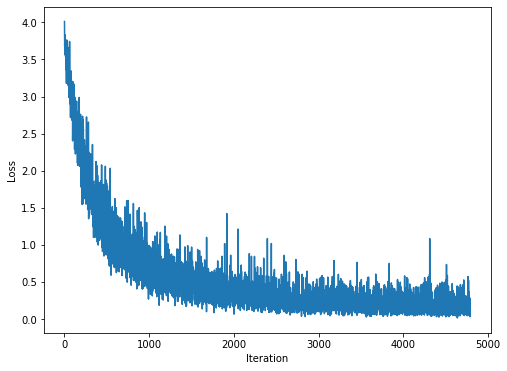

Wrong: 0.03842132775744903


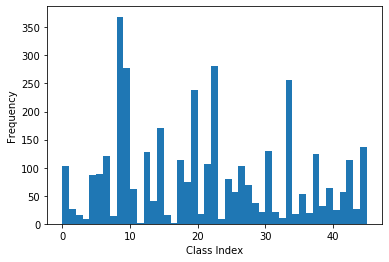

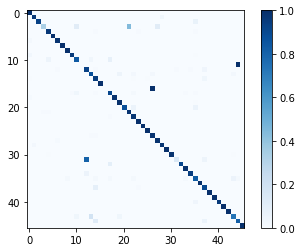

In [166]:
def main():
  ''' Test the classifier. '''

  # collect your paths 
  x_train_path = "x_train.npz"
  y_train_path = "y_train.npz"
  x_test_path = "x_test.npz"
  y_test_path = "y_test.npz"

  # produce your trainsets using PrimarySiteDataSet class
  dataset_train = PrimarySiteDataset(x_path=x_train_path, 
                                     y_path=y_train_path)
  dataset_test = PrimarySiteDataset(x_path=x_test_path, 
                                    y_path=y_test_path)
  
  # What is the train and test set size
  print("Train set size: ", dataset_train.length)
  print("Test set size: ", dataset_test.length)
  
  # get your losses and y' using run
  losses, y, y_predict = run(dataset_train=dataset_train, 
                          dataset_test=dataset_test)
  
  # print final loss and graph
  print("Final loss:", sum(losses[-100:])/100)
  plot_loss(losses)

  # accuracy of algorithm
  rate, y_argMax, y_predict_argMax = accuracy(y, y_predict)
  print("Wrong: {}".format(rate))

  # produce a histogram
  plot_argMax(y_argMax)

  # find FP and NP
  conMatrix = false_Score(y_argMax, y_predict_argMax)
  
  # heatmap of error
  heatmap(conMatrix)
  
main()

## **Part 1**
1. There are 15300 training examples.
2. About 20% of the data is for testing. 
3. 5172 values will be used as an input for gene expression values. 
4. There are 46 types of tissue in the data labels.
5. The size of the output layer should be 46 because we have 46 tissue types in our data.
6. The assigned values in the begining with the y_index_key dictionary are the indicies each type is associated with. 

## **Part 2**
1. Functions are copied above.
2. https://drive.google.com/open?id=13B_Tmagsde8ePY8iDcutKiXL0U818xZb
3. Code was written in to main()

## **Part 3**
1. I realized there wass 5172 inputs and a batch size of 32. We also have 46 output types to align to, therefore our neural net needed an input layer of 5172 inputs, 32 for each hidden layer and 46 for the output layer, after this, the model was functioning with a 2% loss consistently. 

2. The array is 3826 by 46 matrix. 

3. These numbers match because the test set has 3826 pieces of data and each piece of data has 46 values one for each tissue type. 

4. I performed number 4 and the highest number in the $y'$ set did not match with the type in the $y$ set.

5. An  **argmax()** function was produced to return the indicy that has the max value in each list. 

6. The **accuracy()** function was created to iteratively use argmax() to find the rate of error in the classifier. 

7. The **plot_argMax()** function was created to graph the $y$ distribution.

## **Part 4**
Changes to code was made.

## **Part 5**
1. I changed the epochs to 10 instead of 4 and the learning rate to 1e-3. I believe 4 times is not enough to train a model. I first tried to see lower learning rates but only got higher losses so I decied to stay at 1e-3. 

2. My reasoning for choosing those parameters was that I thought the set needed more time to train so I added just one epoch to see if any change happend and the accuracy shot up to 87ish percent. The lower learning rate is so that we are more likely to find the lowest loss than missing it. 

3. If we have 64 nodes in the hidden layer then we have 64 weight parameters. If there is 4 output nodes then we have 4 bias parameters. In our network we are optimizing 64 weight parameters and 46 bias parameters. This is a drastically small number compared to the number of examples in the dataset. I believe there is a risk overfitting from the small size as fewer nodes means less adjustments. We have 46 possible types to consider, which I consider a more complex problem compared to what we saw in 1A.

4. I think a better combination of hyperparameters like more nodes in the hidden layer, a better learning rate, and a diferent optimizer could be found to give a more accurate result for a more complex biology problem. I believe the only way to find out is to first research the other optimizers available, find the optimimum learning rates and epochs for each and just tweak and perform trial and error.

5. Based on the results of the model the most confusing tissues to the model were #44 vaginal and #25 neural. 

6. Generally the more frequent the class is in the data set the more accurate the model was in identifying the correct type. For example such a small number of #23 lymphatic tissue is in the data set and so the model was not able to accurately find identify the tissue type. 